# 特徴抽出

## 特徴量選択 

In [0]:
%matplotlib inline
from sklearn import datasets
import random
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import csv

### データ読み込み
#### Pokemon Image Dataset
https://www.kaggle.com/terminus7/pokemon-challenge

In [2]:
pokemon = pd.read_csv('pokemon.csv')
combats = pd.read_csv('combats.csv')
combats

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151
...,...,...,...
49995,707,126,707
49996,589,664,589
49997,303,368,368
49998,109,89,109


### 前処理

各ポケモンのタイプ、種族値の結合

In [3]:
type_dict = {np.nan:0, 'Normal':1, 'Fighting':2, 'Poison':3, 'Ground':4, 'Flying':5, 'Bug':6, 'Rock':7, 'Ghost':8, 'Steel':9, 'Fire':10, 'Water':11, 'Electric':12, 'Grass':13, 'Ice':14, 'Psychic':15, 'Dragon':16, 'Dark':17, 'Fairy':18}
pokemon['Type 1'] = pokemon['Type 1'].map(type_dict)
pokemon['Type 2'] = pokemon['Type 2'].map(type_dict)
pokemon

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,13,3,45,49,49,65,65,45,1,False
1,2,Ivysaur,13,3,60,62,63,80,80,60,1,False
2,3,Venusaur,13,3,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,13,3,80,100,123,122,120,80,1,False
4,5,Charmander,10,0,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,7,18,50,100,150,100,150,50,6,True
796,797,Mega Diancie,7,18,50,160,110,160,110,110,6,True
797,798,Hoopa Confined,15,8,80,110,60,150,130,70,6,True
798,799,Hoopa Unbound,15,17,80,160,60,170,130,80,6,True


各ポケモンの種族値、タイプ情報をcombatsに結合

In [4]:
df_first = pokemon.loc[combats['First_pokemon'] - 1]
df_first = df_first.reset_index()
df_second = pokemon.loc[combats['Second_pokemon'] - 1]
df_second = df_second.reset_index()
combats = combats.join(df_first).drop(['index', '#', 'Name', 'Generation', 'Legendary'], axis=1).rename(columns={'Type 1':'First_Type 1', 'Type 2':'First_Type 2', 'HP':'First_HP', 'Attack':'First_Attack', 'Defense':'First_Defense', 'Sp. Atk':'First_Sp. Atk', 'Sp. Def':'First_Sp. Def', 'Speed':'First_Speed'})
combats = combats.join(df_second).drop(['index', '#', 'Name', 'Generation', 'Legendary'], axis=1).rename(columns={'Type 1':'Second_Type 1', 'Type 2':'Second_Type 2', 'HP':'Second_HP', 'Attack':'Second_Attack', 'Defense':'Second_Defense', 'Sp. Atk':'Second_Sp. Atk', 'Sp. Def':'Second_Sp. Def', 'Speed':'Second_Speed'})
combats.Winner[combats.Winner == combats.First_pokemon] = 0
combats.Winner[combats.Winner == combats.Second_pokemon] = 1
combats

,First_pokemon,Second_pokemon,Winner,First_Type 1,First_Type 2,First_HP,First_Attack,First_Defense,First_Sp. Atk,First_Sp. Def,First_Speed,Second_Type 1,Second_Type 2,Second_HP,Second_Attack,Second_Defense,Second_Sp. Atk,Second_Sp. Def,Second_Speed
0,266,298,1,7,4,50,64,50,45,50,41,13,17,70,70,40,60,40,60
1,702,701,1,13,2,91,90,72,90,129,108,7,2,91,129,90,72,90,108
2,191,668,1,18,5,55,40,85,80,105,40,15,0,75,75,75,125,95,40
3,237,683,1,10,0,40,40,40,70,40,20,16,0,77,120,90,60,90,48
4,151,231,0,7,11,70,60,125,115,70,55,6,7,20,10,230,10,230,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,0,16,10,100,120,100,150,120,90,11,0,30,40,70,70,25,60
49996,589,664,0,4,0,60,85,40,30,45,68,12,0,35,55,40,45,40,60
49997,303,368,1,11,5,60,50,100,85,70,65,1,0,73,115,60,60,60,90
49998,109,89,0,12,0,40,30,50,55,55,100,12,9,25,35,70,95,55,45


特徴量、ラベルの作成

In [5]:
y = combats['Winner']
X = combats.drop(['First_pokemon', 'Second_pokemon', 'Winner'], axis=1)
X

,First_Type 1,First_Type 2,First_HP,First_Attack,First_Defense,First_Sp. Atk,First_Sp. Def,First_Speed,Second_Type 1,Second_Type 2,Second_HP,Second_Attack,Second_Defense,Second_Sp. Atk,Second_Sp. Def,Second_Speed
0,7,4,50,64,50,45,50,41,13,17,70,70,40,60,40,60
1,13,2,91,90,72,90,129,108,7,2,91,129,90,72,90,108
2,18,5,55,40,85,80,105,40,15,0,75,75,75,125,95,40
3,10,0,40,40,40,70,40,20,16,0,77,120,90,60,90,48
4,7,11,70,60,125,115,70,55,6,7,20,10,230,10,230,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,16,10,100,120,100,150,120,90,11,0,30,40,70,70,25,60
49996,4,0,60,85,40,30,45,68,12,0,35,55,40,45,40,60
49997,11,5,60,50,100,85,70,65,1,0,73,115,60,60,60,90
49998,12,0,40,30,50,55,55,100,12,9,25,35,70,95,55,45


### 特徴量の順位付け

Feature ranking:
1. Second_Speed (0.385272)
2. First_Speed (0.365466)
3. First_Attack (0.051277)
4. First_Sp. Atk (0.046687)
5. Second_Attack (0.044482)
6. Second_Sp. Atk (0.038234)
7. First_HP (0.023039)
8. First_Sp. Def (0.014137)
9. Second_Sp. Def (0.012036)
10. Second_HP (0.009381)
11. First_Defense (0.004715)
12. Second_Defense (0.003208)
13. First_Type 1 (0.000896)
14. Second_Type 1 (0.000646)
15. First_Type 2 (0.000275)
16. Second_Type 2 (0.000250)


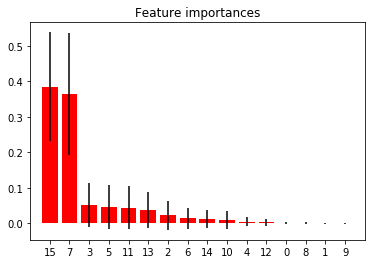

In [6]:
feature_name = ["First_Type 1", "First_Type 2", "First_HP", "First_Attack", "First_Defense", "First_Sp. Atk",
                "First_Sp. Def", "First_Speed", "Second_Type 1", "Second_Type 2", "Second_HP", "Second_Attack", 
                "Second_Defense", "Second_Sp. Atk", "Second_Sp. Def", "Second_Speed"]

RF = RandomForestClassifier(max_depth=4, random_state=1)

RF.fit(X, y)
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_name[indices[f]], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## 識別境界面の可視化

In [0]:
# K近傍法の近傍数パラメータ k
neighbors_list = [3,5,9,17]
# テストデータ分割のための乱数のシード（整数値）
random_seed = 1
#　テストデータの割合
test_proportion = 0.3

d_list = [(7,15)]

In [0]:
# 標準化
X_scale = scale(X.values)

### 訓練用データとテストデータの分割

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=test_proportion, random_state=random_seed,)

### KNNモデルの特徴の次元を指定した訓練データによる学習

In [0]:
fitted_models = []
for neighbors in  neighbors_list:
  for d in d_list:
    d1, d2 = d
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    fitted_model = knn.fit(X_train[:, [d1, d2]], y_train)
    fitted_models.append((fitted_model, neighbors, d1, d2))

### 使用する特徴量ごとの評価

In [11]:
for model in fitted_models:
  knn,  neighbors, d1, d2 = model
  acc_train = accuracy_score(y_train, knn.predict(X_train[:, [d1, d2]]))
  acc_test  = accuracy_score(y_test, knn.predict(X_test[:, [d1, d2]]))
  print('k=%d, features=(%d,%d)' % (neighbors, d1, d2))
  print('accuracy for training data: %f' % acc_train)
  print('accuracy for test data: %f' % acc_test)

k=3, features=(7,15)
accuracy for training data: 0.932714
accuracy for test data: 0.921667
k=5, features=(7,15)
accuracy for training data: 0.941886
accuracy for test data: 0.932467
k=9, features=(7,15)
accuracy for training data: 0.941114
accuracy for test data: 0.934267
k=17, features=(7,15)
accuracy for training data: 0.939657
accuracy for test data: 0.934333


### 識別境界面をプロット

In [0]:
def plot_decision_boundary(model):
    knn,  neighbors, d1, d2 = model
    x1_min, x1_max = X_train[:, d1].min() - 0.5, X_train[:, d1].max() + 0.5
    x2_min, x2_max = X_train[:, d2].min() - 0.5, X_train[:, d2].max() + 0.5
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
                       
    Z = knn.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    plt.figure(figsize=(10,10))
    plt.subplot(211)

    plt.contourf(xx1, xx2, Z, alpha=0.5, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    #random.randint()
    for idx, cl in enumerate(np.unique(y_train)):
        size = random.randint(0, X_train[y_train == cl, d1].shape[0] - 100)
        plt.scatter(x=X_train[y_train == cl, d1][size:size+100], y=X_train[y_train == cl, d2][size:size+100],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl)


    plt.xlabel(feature_name[d1])
    plt.ylabel(feature_name[d2])
    plt.title('train_data,'+ str(neighbors) + ',' + str(d1)+ ',' + str(d2))

    plt.subplot(212)

    plt.contourf(xx1, xx2, Z, alpha=0.5, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y_test)):
        size = random.randint(0, X_test[y_test == cl, d1].shape[0] - 100)
        plt.scatter(x=X_test[y_test == cl, d1][size:size+100], y=X_test[y_test == cl, d2][size:size+100],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl)


    plt.xlabel(feature_name[d1])
    plt.ylabel(feature_name[d2])
    plt.title('test_data,'+ str(neighbors) + ',' + str(d1)+ ',' + str(d2))
    plt.show()

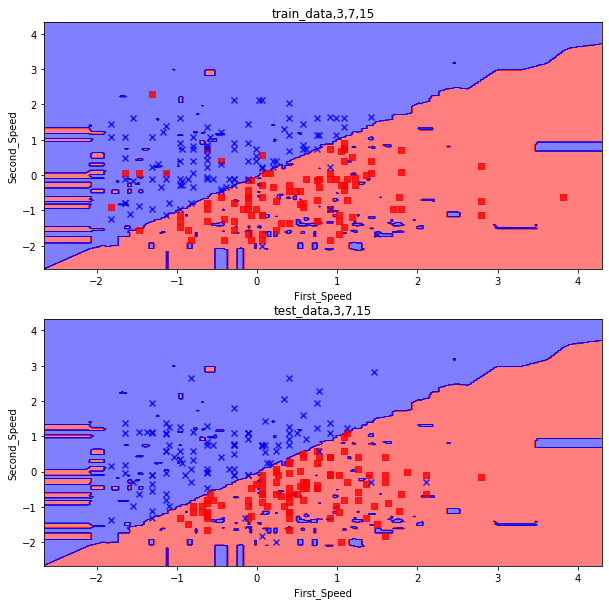

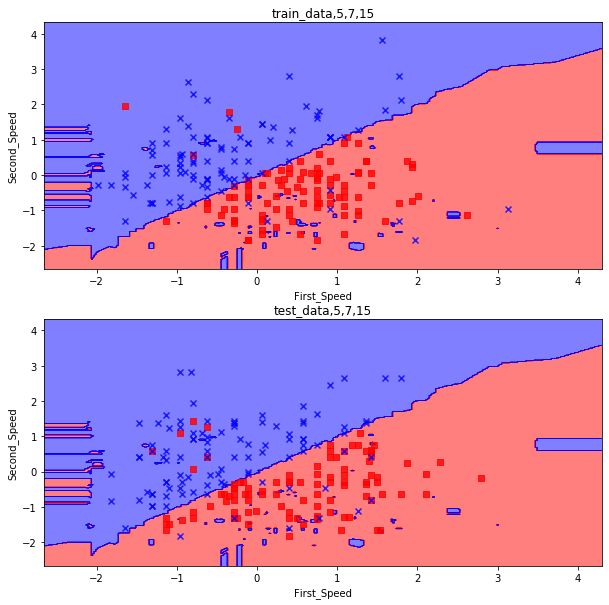

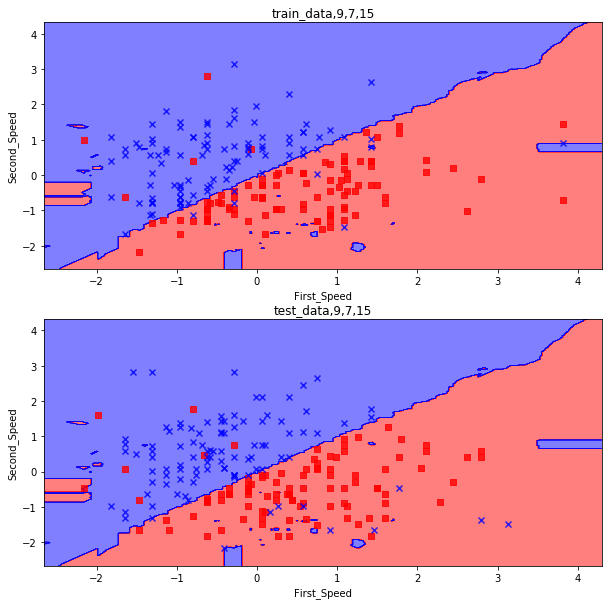

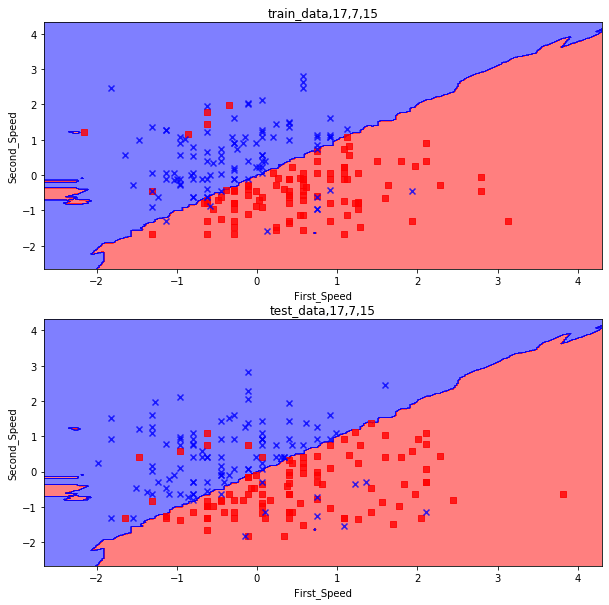

In [13]:
for model in fitted_models:
  knn,  neighbors, d1, d2 = model
  plot_decision_boundary(model)

## PCA

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
# PCAで2次元に圧縮
pca = PCA(n_components=2)
X_pca= pca.fit_transform(X)

In [0]:
x1_min, x1_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
x2_min, x2_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))

markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y))])
    
def plot_decision_boundary_PCA(Z1, classifer_name):

    Z1 = Z1.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z1, alpha=0.5, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        size = random.randint(0, X_pca[y == cl].shape[0] - 100)
        plt.scatter(x=X_pca[y == cl, 0][size:size + 100], y=X_pca[y == cl, 1][size:size + 100],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl)

    plt.xlabel('pca1')
    plt.ylabel('pca2')
    plt.title(classifer_name)
    
    plt.show()

In [0]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3)

In [0]:
score_funcs = ['accuracy']

### 決定木

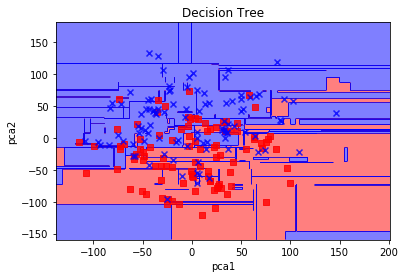

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


TrainAve: 0.7369481481481481
TestAve: 0.6845333333333334


In [19]:
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=10,
                              random_state=1)

tree.fit(X_train, y_train)
Z = tree.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
plot_decision_boundary_PCA(Z, 'Decision Tree')

# クロスバリデーションによる評価（学習データ，テストデータ）を追加
kfold = KFold(n_splits=10, random_state=1)

cv_results = cross_validate(tree, X_test, y_test, cv = kfold, return_train_score = True)

print('TrainAve: {}'.format(np.mean(cv_results['train_score'])))
print('TestAve: {}'.format(np.mean(cv_results['test_score'])))


### Gradient Boosting

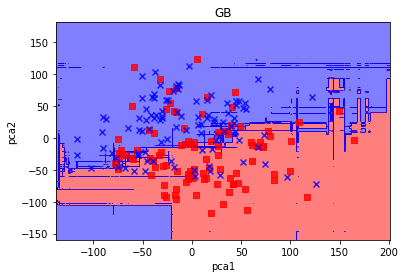

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


TrainAve: 0.7231925925925926
TestAve: 0.6974


In [20]:
GB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
        max_depth=4)

GB.fit(X_train, y_train)
Z = GB.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
plot_decision_boundary_PCA(Z, 'GB')

kfold = KFold(n_splits=10, random_state=1)

cv_results = cross_validate(GB, X_test, y_test, cv = kfold, return_train_score = True)

print('TrainAve: {}'.format(np.mean(cv_results['train_score'])))
print('TestAve: {}'.format(np.mean(cv_results['test_score'])))
